1) IMPORT LIBRARIES

In [ ]:
!python -m spacy download el_core_news_sm 

In [ ]:
! pip install dateparser         #Parse dates written using natural language into python

import spacy

import requests                            
from bs4 import BeautifulSoup as soup  

import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
plt.style.use('ggplot')
import numpy as np 
import glob 
import re    
from datetime import datetime
import dateparser
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


2) READ THE CSV FILE & DATA PRE-PROCESSING

In [ ]:
from google.colab import drive      
drive.mount('/content/gdrive')

        #reading the csv 
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Scrape_efsyn.csv") #parse_dates=['Time'], date_parser= dateparser.parse]  

Mounted at /content/gdrive


In [ ]:
df.head(10)

,Title,Summary,Time
0,"Τους ψήφισαν, τους επέτρεψαν, είναι καιρός να ...",Εδώ και λίγες μέρες με τις ψήφους μόνο της Ν....,"08.07.2021, 16:00"
1,"Τώρα και για τους εκπαιδευτικούς, μόρια αντί γ...",Τη λειτουργία «εκπαιδευτικών ομίλων» μετά τη ...,"05.07.2021, 10:27"
2,Οι κρίσεις και το δόγμα του ατομισμού,Σκεφτείτε τι θα γινόταν αν ο καύσωνας της προ...,"05.07.2021, 04:00"
3,Το ασφαλιστικό των millennials,Είναι αναγκαίο να υπάρξει αλλαγή υποδείγματος...,"04.07.2021, 10:26"
4,Της Αλλοπάρ*,"Οι συλλεκτικές, διασκεδαστικές και, γενικά, α...","03.07.2021, 06:00"
5,Τσίπρας: Νέα αρχή με στόχο τη νίκη απέναντι στ...,Λάβρος κατά της κυβέρνησης και του πρωθυπουργ...,"02.07.2021, 21:31"
6,Γεννηματά: «Για την πανδημία δεν αρκεί η επικο...,Τον επικοινωνιακό τρόπο με τον οποίο επιλέγει...,"02.07.2021, 06:00"
7,"Ιδιος ο στόχος, αλλάζει μόνο ο τρόπος",Στόχος της Δεξιάς είναι η δημιουργία ενός καθ...,"28.06.2021, 16:00"
8,Υποτιμώντας μέχρι θανάτου τη γυναίκα,Η ρίζα του κακού βρίσκεται στον τρόπο εγγραφή...,"27.06.2021, 15:41"
9,Στην Ελλάδα το να ονομαστείς σκηνοθέτης θεωρεί...,"Ερμηνεύει τον Οθέλλο στο έργο του Σέξπιρ, επι...","27.06.2021, 11:12"


In [ ]:
#converting 'Time' from str to datetime
df['Time'] = pd.to_datetime(df.Time , format='%d.%m.%Y, %H:%M')
df['Time']

In [ ]:
df['year'] = pd.DatetimeIndex(df['Time']).year
df['month'] = pd.DatetimeIndex(df['Time']).month
df['day'] = pd.DatetimeIndex(df['Time']).day
df

,Title,Summary,Time,year,month,day
0,"Τους ψήφισαν, τους επέτρεψαν, είναι καιρός να ...",Εδώ και λίγες μέρες με τις ψήφους μόνο της Ν....,2021-07-08 16:00:00,2021,7,8
1,"Τώρα και για τους εκπαιδευτικούς, μόρια αντί γ...",Τη λειτουργία «εκπαιδευτικών ομίλων» μετά τη ...,2021-07-05 10:27:00,2021,7,5
2,Οι κρίσεις και το δόγμα του ατομισμού,Σκεφτείτε τι θα γινόταν αν ο καύσωνας της προ...,2021-07-05 04:00:00,2021,7,5
3,Το ασφαλιστικό των millennials,Είναι αναγκαίο να υπάρξει αλλαγή υποδείγματος...,2021-07-04 10:26:00,2021,7,4
4,Της Αλλοπάρ*,"Οι συλλεκτικές, διασκεδαστικές και, γενικά, α...",2021-07-03 06:00:00,2021,7,3
...,...,...,...,...,...,...
295,Ηλιόπουλος: Επικίνδυνη η Ν.Δ. – κεντρική η μάχ...,Ο εκπρόσωπος Τύπου του ΣΥΡΙΖΑ-ΠΣ εστίασε στο ...,2021-04-17 17:25:00,2021,4,17
296,Βαρουφάκης: Το εργασιακό νομοσχέδιο του Κ. Χατ...,Κριτική στο νομοσχέδιο του Κ. Χατζηδάκη που θ...,2021-04-17 17:00:00,2021,4,17
297,ΣΥΡΙΖΑ: Η κυβέρνηση Μητσοτάκη οδηγεί σε ανεξέλ...,«Η κυβέρνηση έχει κηρύξει πόλεμο στους εργαζο...,2021-04-16 12:39:00,2021,4,16
298,Πώς έγινε... άνθρακες ο «χρυσός» του Πρίνου;,Σε δεινή θέση βρίσκεται η εταιρεία Energean K...,2021-04-16 12:13:00,2021,4,16


In [ ]:
#Set datetime as index
df.set_index('Time', inplace= True)
df.head(5)

In [ ]:
df.dtypes

Title      object
Summary    object
year        int64
month       int64
day         int64
dtype: object

In [ ]:
#converting data type from object to string
df['Summary']= df['Summary'].astype(str)

In [ ]:
#converting data type from object to string
df['Title']= df['Title'].astype(str)

In [ ]:
#print the whole heading (need some cleaning)
pd.set_option("display.max_colwidth", -1)
print(df['Title'])

In [ ]:
#Cleaning the text
def cleanTxt(text):
  text = re.sub(r'[^\w\s]', '', text)   #Removing puncuations
  text = text.lower()                     #Converting letters to lowercase
  text = text.replace('\xa0','')       #Removing \xa0 character(it means space)  
  text = text.replace('\t','')        #Removing \t character(similar to the indentation function in the document,Tab key) 
  text = text.replace('\n','')                                                                                          
  #text = re.sub('\d+', '', text)      #Removing numbers             
# Return the cleaned text
  return text
#Clean the tweets
df['Summary'] = df['Summary'].apply(cleanTxt)
df['Title'] =  df['Title'].apply(cleanTxt)
#Show the cleaned tweets
df.head(100)

,Title,Summary,year,month,day
Time,,,,,
2021-07-08 16:00:00,τους ψήφισαν τους επέτρεψαν είναι καιρός να αντιδράσουν,εδώ και λίγες μέρες με τις ψήφους μόνο της νδ αποτελεί νόμο του κράτους το νέο εργασιακό νομοσχέδιο ή καλύτερα η ταφόπλακα των δικαιωμάτων και των κεκτημένων των εργαζομένων,2021,7,8
2021-07-05 10:27:00,τώρα και για τους εκπαιδευτικούς μόρια αντί για αμοιβή,τη λειτουργία εκπαιδευτικών ομίλων μετά τη λήξη του ημερήσιου ωρολογίου προγράμματος διδασκαλίας προβλέπει το νέο νομοσχέδιο του υπουργείου παιδείας,2021,7,5
2021-07-05 04:00:00,οι κρίσεις και το δόγμα του ατομισμού,σκεφτείτε τι θα γινόταν αν ο καύσωνας της προηγούμενης εβδομάδας διαρκούσε περισσότερο και οι θερμοκρασίες ήταν υψηλότερες οποιαδήποτε δραστηριότητα σε εξωτερικό χώρο που θα συνεπάγεται σωματική,2021,7,5
2021-07-04 10:26:00,το ασφαλιστικό των millennials,είναι αναγκαίο να υπάρξει αλλαγή υποδείγματος στο ασφαλιστικό αλλά και σε πολλούς ακόμη τομείς της δημόσιας ζωής η εισαγωγή της ανταποδοτικότητας στις επικουρικές συντάξεις η δημιουργία δηλαδή ενός ατομικού,2021,7,4
2021-07-03 06:00:00,της αλλοπάρ,οι συλλεκτικές διασκεδαστικές και γενικά απολαυστικές εκπομπές στο ραδιόφωνο του σκαϊ,2021,7,3
...,...,...,...,...,...
2021-06-11 13:10:00,κυρανάκης θα μπορείτε τώρα να δουλεύετε υπερωρίες για να πάτε στον γιατρό,αδιανόητα επιχειρήματα για ακόμη μια φορά από τον βουλευτή της νδ ο οποίος είτε αγνοεί πλήρως τα ισχύοντα εργασιακά δικαιώματα ή αδιαφορεί παντελώς για αυτά,2021,6,11
2021-06-11 09:41:00,συλλαλητήρια και στην κρήτη μαζικό οχι στο νέο εργασιακό νομοσχέδιο,με μεγάλη συμμετοχή και με βασικό αίτημα την απόσυρση του νέου εργασιακού νομοσχεδίου του υπουργείου εργασίας πραγματοποιήθηκαν την πέμπτη τα συλλαλητήρια στην κρήτη στο πλαίσιο της 24ωρης απεργίας της 10ης,2021,6,11
2021-06-11 07:50:00,στοπειθαρχικό στέλνει ηεσηεατους απεργοσπάστες τουσκαϊ,tον γενικό διευθυντή ενημέρωσης του σκαϊ βασίλη παπαδρόσο και τον δημοσιογράφο νίκο υποφάντη παραπέμπει η εσηεα και ζητά τη διερεύνηση τυχόν άλλων υπευθύνων,2021,6,11


In [ ]:
#convert from int to string(month name)
df['month'] = pd.to_datetime(df['month'], format='%m').dt.month_name().str.slice(stop=3)

4) NATURAL LANGUAGE PROCESSING

In [ ]:
#Greek language
nlp = spacy.load('el_core_news_sm')

In [ ]:
#Greek stopwords are included in this list
list(nlp.Defaults.stop_words)[0:10]

In [ ]:
GreekStopwords = nlp.Defaults.stop_words

In [ ]:
#Save the greek stopwords in a variable
NewStopWords = list(GreekStopwords)

In [ ]:
#Concatenate
title = df['Title'].str.cat(sep = ' ')
print(len(title), 'items')
title

In [ ]:
summary = df['Summary'].str.cat(sep = ' ')
print(len(summary) , 'items')
summary

In [ ]:
#merge summary + title together
whole_text = summary + title
print(len(whole_text) , 'items')
whole_text

5) LEMMATIZATION: THE PROCESS OF RETURNING THE BASE OR DICTIONARY FORM OF A WORD (LEMMA)

In [ ]:
#print only the lemma for every word
full_text = nlp(whole_text)
for token in full_text:       
    print(token.lemma_)

In [ ]:
#Modify the full text by replacing every word with its lemma.
final_text = ' '.join(token.lemma_ for token in full_text)
final_text[5:200]

In [ ]:
#Store the clear/lemmatized full text in a variable
full_doc = nlp(final_text)
full_doc

In [ ]:
clear_text = ' '.join(token.lemma_ for token in full_doc)
clear_text[:500]


In [ ]:
NewStopWords.append('συριζαπς')
NewStopWords.append('να')
NewStopWords.append('στι')
NewStopWords.append('λέω')
NewStopWords.append('μιλά')
NewStopWords.append('κάνω')
NewStopWords.append('αποτελώ')
NewStopWords.append('θέση')
NewStopWords.append('τονίζω')
NewStopWords.append('ζητώ')

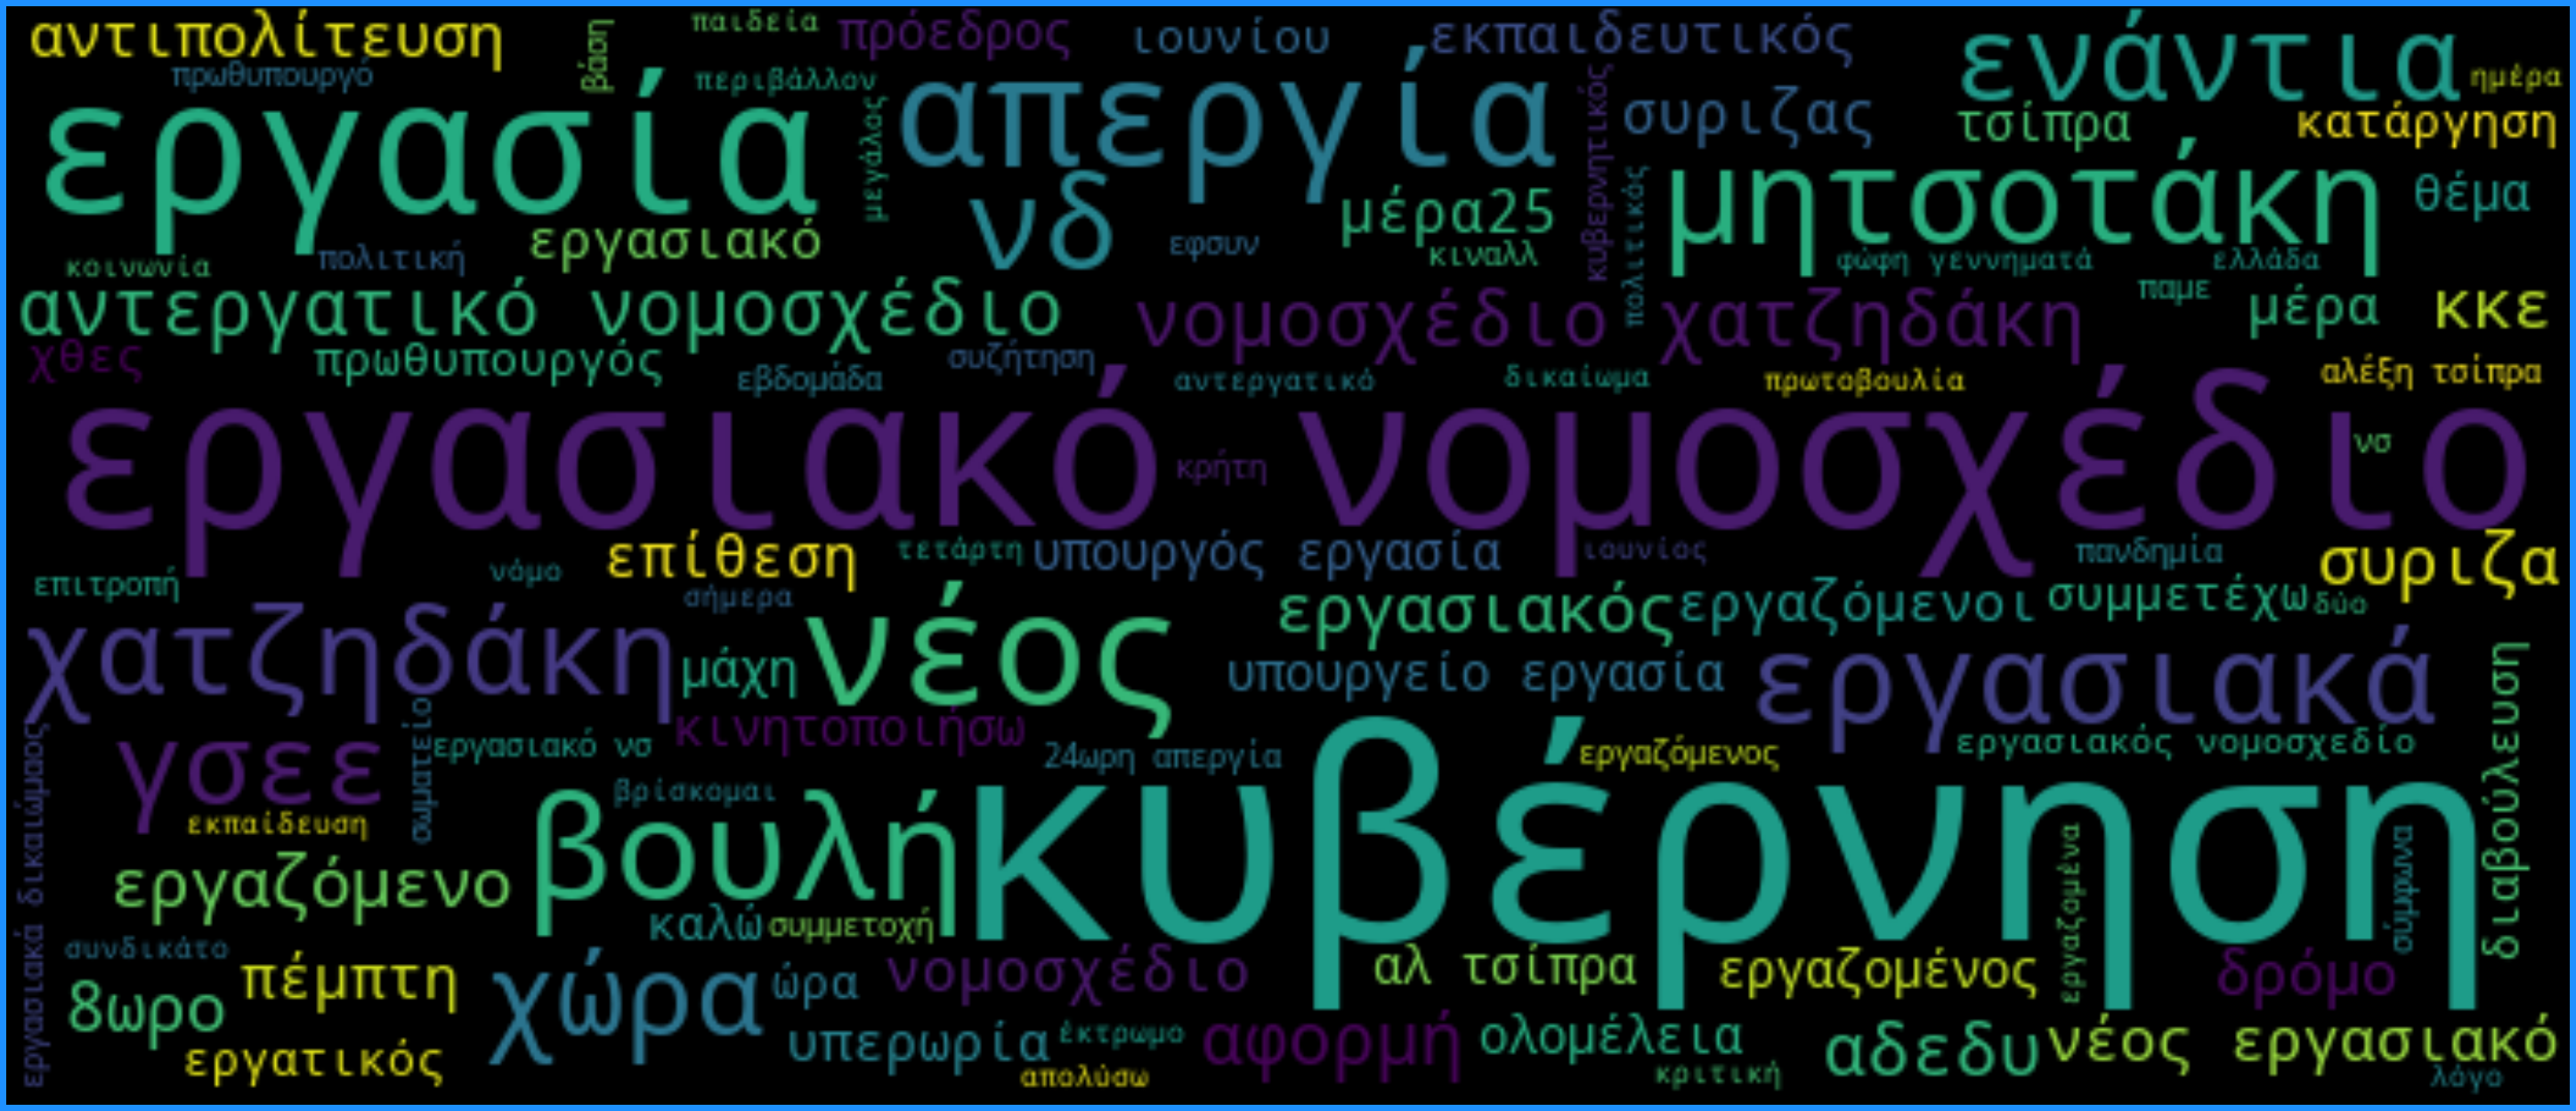

In [ ]:
wordcloud = WordCloud(stopwords = NewStopWords, width = 700, height = 300, max_words = 100, background_color = 'black').generate(clear_text)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'dodgerblue',
    edgecolor = 'green')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

6) VECTORIZATION : 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer    #Vectorization
from html import unescape           #throw 'trash' words

In [ ]:
cv = CountVectorizer()

In [ ]:
#transform from text to vector
titles_vector = cv.fit_transform(df['Title'])

In [ ]:
summary_vector = cv.fit_transform(df['Summary'])

In [ ]:
def my_tokenizer(full_text):
   # apply the preprocessing and tokenization steps
    text_clean = unescape(full_text).lower()  
    tokens = nlp(text_clean)  
    lemmatized_tokens = [token.lemma_ for token in tokens if (len(str(token.lemma_))>2)]

    # use CountVectorizer's _word_ngrams built in method
    # to remove stop words and extract n-grams
    return lemmatized_tokens


In [ ]:
cv = CountVectorizer(stop_words= NewStopWords, min_df=0.01, max_df=0.95,tokenizer= my_tokenizer) 
titles_vector = cv.fit_transform(df['Title']) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['έγκαιρος', 'έκασ', 'έκασα', 'έξαφνος', 'έτερου', 'ίσιος', 'αδιάκοπο', 'αλλιώτικας', 'αλλοιώτικο', 'αφότο', 'βεβαιόταα', 'γρήγορας', 'δίχω', 'εαυτά', 'εκάστα', 'εκάστο', 'ετού', 'ετούτε', 'ευθύ', 'εχτής', 'ιδίο', 'καθενό', 'κανενό', 'μέλλομαι', 'μεμιά', 'μερικού', 'μερικός', 'μπορώ', 'μόνα', 'ολωσδιόλο', 'ολόγυρο', 'ορισμένος', 'ορισμένω', 'ποιέ', 'ποιής', 'ποιώ', 'πολλός', 'προχθή', 'προχτά', 'πόσα', 'πόσο', 'σει', 'στος', 'συριζαπ', 'συχνά', 'ταύτο', 'τόσε', 'όποιας', 'όσε'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
cv_summary = CountVectorizer(stop_words= NewStopWords, min_df=0.01, max_df=0.95,tokenizer= my_tokenizer) 
summary_vector = cv.fit_transform(df['Summary']) 

In [ ]:
#create dataframe with vectorized titles
titles_results = pd.DataFrame(titles_vector.toarray(), columns=cv.get_feature_names()) 
titles_results

,24ωρη,8ωρο,live,έκτρωμο,αδεδυ,αλληλοβοήθεια,αντεργατικό,αντεργατικός,αντιπολίτευση,απεργία,απολύσει,αυριανός,βουλή,γεννηματά,γσεε,δηλώσει,δικαιώμαα,δρόμο,δρόμου,δύο,εκπαιδευτικός,ενάντια,επίθεση,επιστροφή,εργαζόμενοι,εργασία,εργασιακά,εργασιακό,εργασιακός,εργατικός,ιουνίου,κατάργηση,κιναλλ,κινητοποιήσει,κκε,κρήτη,κυβέρνηση,κυβερνητικός,μάχη,μέρα,μέρα25,μαζικός,μεγάλος,μεσαίωνας,μητσοτάκη,νέος,νομοσχέδιο,νομοσχεδίο,ολομέλεια,παμε,πανδημία,πενεν,συμμετέχω,συνδικάτο,συριζας,σφυροκόπημα,σωματείο,ταμείο,τετάρτη,τσίπρα,υπερωρία,υπουργός,χατζηδάκη
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
297,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cv = CountVectorizer(stop_words= NewStopWords, analyzer='word', 
                     min_df=0.02, max_df=0.60, max_features=100, tokenizer=my_tokenizer)
titles_vector = cv.fit_transform(df['Title'])
titles_results = pd.DataFrame(titles_vector.toarray(), columns=cv.get_feature_names()) 

titles_results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['έγκαιρος', 'έκασ', 'έκασα', 'έξαφνος', 'έτερου', 'ίσιος', 'αδιάκοπο', 'αλλιώτικας', 'αλλοιώτικο', 'αφότο', 'βεβαιόταα', 'γρήγορας', 'δίχω', 'εαυτά', 'εκάστα', 'εκάστο', 'ετού', 'ετούτε', 'ευθύ', 'εχτής', 'ιδίο', 'καθενό', 'κανενό', 'μέλλομαι', 'μεμιά', 'μερικού', 'μερικός', 'μπορώ', 'μόνα', 'ολωσδιόλο', 'ολόγυρο', 'ορισμένος', 'ορισμένω', 'ποιέ', 'ποιής', 'ποιώ', 'πολλός', 'προχθή', 'προχτά', 'πόσα', 'πόσο', 'σει', 'στος', 'συριζαπ', 'συχνά', 'ταύτο', 'τόσε', 'όποιας', 'όσε'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,24ωρη,8ωρο,έκτρωμο,αντεργατικό,απεργία,βουλή,γσεε,ενάντια,εργαζόμενοι,εργασία,εργασιακό,εργασιακός,κκε,κρήτη,κυβέρνηση,μητσοτάκη,νέος,νομοσχέδιο,συριζας,τσίπρα,χατζηδάκη
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


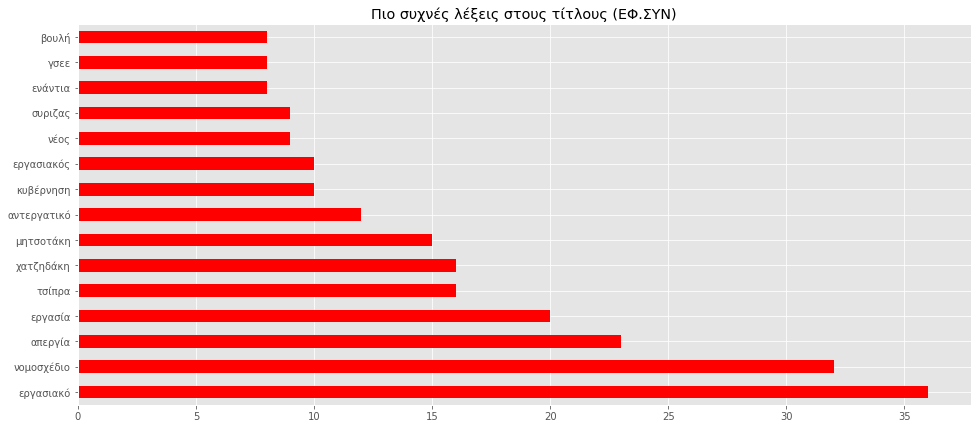

In [ ]:
#the most used words in news articles titles
sum_titles_words = titles_results.sum(axis =0, skipna= True)
sum_titles_words.sort_values(ascending= False).head(15).plot(kind='barh', color='r', grid= True, title= 'Πιο συχνές λέξεις στους τίτλους (EΦ.ΣΥΝ)',
                                                             figsize= (16,7)) 

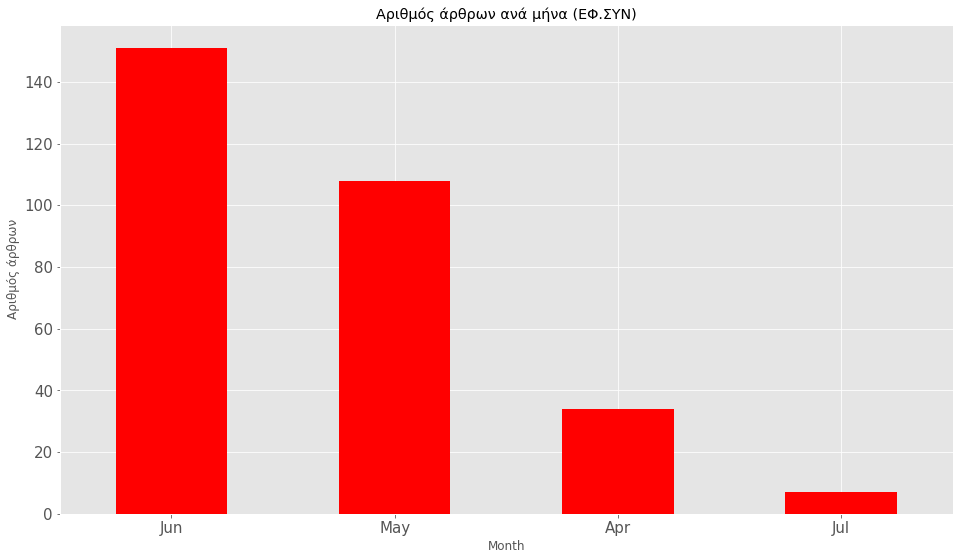

In [ ]:
#Plot number of articles per month
df['month'].value_counts(ascending= False).plot(kind= 'bar', xlabel= 'Month', ylabel= 'Αριθμός άρθρων', color='r', 
                                                title= 'Αριθμός άρθρων ανά μήνα (ΕΦ.ΣΥΝ)', figsize= (16,9), fontsize= 15, rot= 0)

In [ ]:
# Create bigrams
cv = CountVectorizer( stop_words= NewStopWords, max_features=50, ngram_range=(2, 2), 
                     tokenizer=my_tokenizer, min_df= 0.01, max_df= 0.50, analyzer= 'word')
count_vector = cv.fit_transform(df['Title'])
work_words = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
work_words.head()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['έγκαιρος', 'έκασ', 'έκασα', 'έξαφνος', 'έτερου', 'ίσιος', 'αδιάκοπο', 'αλλιώτικας', 'αλλοιώτικο', 'αφότο', 'βεβαιόταα', 'γρήγορας', 'δίχω', 'εαυτά', 'εκάστα', 'εκάστο', 'ετού', 'ετούτε', 'ευθύ', 'εχτής', 'ιδίο', 'καθενό', 'κανενό', 'μέλλομαι', 'μεμιά', 'μερικού', 'μερικός', 'μπορώ', 'μόνα', 'ολωσδιόλο', 'ολόγυρο', 'ορισμένος', 'ορισμένω', 'ποιέ', 'ποιής', 'ποιώ', 'πολλός', 'προχθή', 'προχτά', 'πόσα', 'πόσο', 'σει', 'στος', 'συριζαπ', 'συχνά', 'ταύτο', 'τόσε', 'όποιας', 'όσε'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,24ωρη απεργία,έκτρωμο χατζηδάκη,αντεργατικό έκτρωμο,αντεργατικό νομοσχέδιο,αυριανός απεργία,ενάντια εργασιακό,εργασιακό μεσαίωνας,εργασιακό νομοσχέδιο,νέος εργασιακό,νομοσχέδιο χατζηδάκη,ταμείο αλληλοβοήθεια,τσίπρα κυβέρνηση
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sum_work_words = work_words.sum(axis =0)

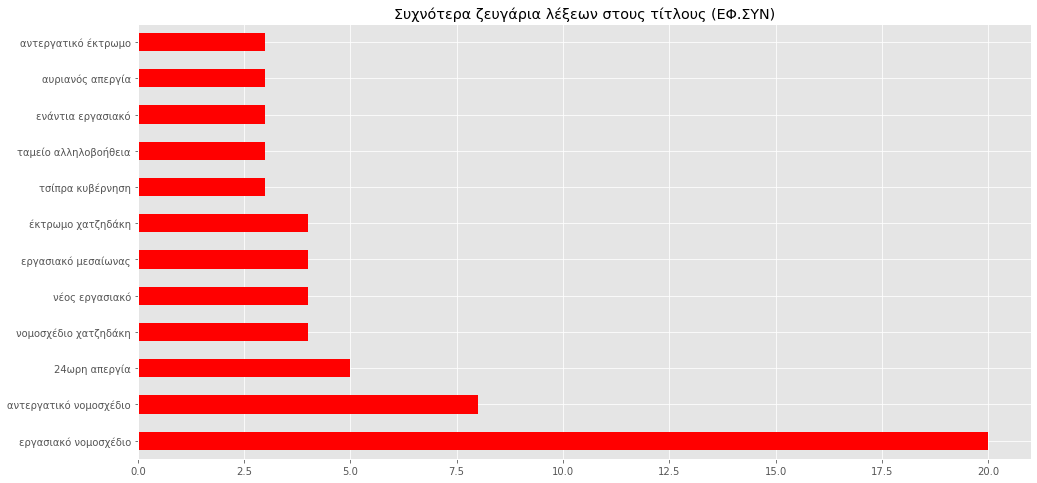

In [ ]:
sum_work_words.sort_values(ascending= False).plot(kind='barh',color='r', grid= True, 
                                                  title= 'Συχνότερα ζευγάρια λέξεων στους τίτλους (ΕΦ.ΣΥΝ)',
                                                  figsize= (16,8)) 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words= NewStopWords, max_features=200)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(df['Summary'])

In [ ]:
summary_results = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names()) 
summary_results

,10,10ης,24ωρη,8ωρο,έκτρωμα,αδεδυ,αλ,αλέξη,αλέξης,αλλαγής,ανάγκη,αναμένεται,ανθρώπων,αντεργατικό,αντιδρώντας,αντιπαράθεση,αντιπολίτευση,αντιπολίτευσης,αξιωματικής,απεργία,απεργίας,απεργιακές,απεργιακή,απολύσεων,αποτελεί,αποφάσισαν,απόλυσης,απόσυρση,αρχές,αρχίζει,αφορμή,βάση,βασικό,βουλή,βουλής,βρίσκεται,γενική,γεννηματά,γραμμάτιο,γσεε,...,στελέχη,στιγμή,συζήτηση,συλλογικές,συμβάσεις,συμμετέχουν,συμμετοχή,συνέχεια,συνδικάτα,συριζα,σφοδρή,σχέδιο,σχέσεις,σωματεία,σύμφωνα,σύστημα,τονίζει,τσίπρα,τσίπρας,τόνισε,υπερωρίες,υπουργείο,υπουργείου,υπουργού,υπουργό,υπουργός,φέρει,φαίνεται,φορά,φορείς,φώφη,χαρακτήρισε,χατζηδάκη,χθες,χρόνια,χώρα,χώρας,χώρο,ψήφιση,ώρα
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312567,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train[0:1], tfidf_matrix_train))

In [ ]:
array = cosine_similarity(tfidf_matrix_train , tfidf_matrix_train )
array

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap

In [ ]:
df_similar = pd.DataFrame(array)

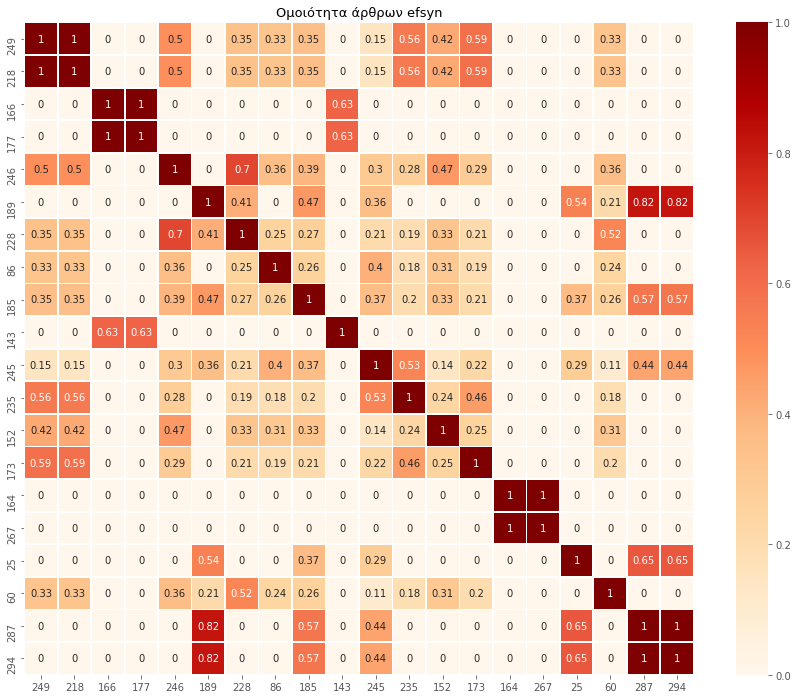

In [ ]:
score = []
for index, row in df_similar.iterrows():
  score.append({ 'index' : index, 'score': row.sort_values(ascending = False).head(20).sum()})

# Ορίζουμε ως dataframe την συνθήκη που κάναμε πριν
score = pd.DataFrame(score)


# Παίρνουμε τα 20 άρθρα από το dataframe scores1
high_score = score.sort_values('score', ascending=False).head(20)

# Στη συνέχεια παίρουμε τα άρθρα, το index και τις στήλες από τα 20 άρθρα με τη μεγαλύτερη ομοιότητα.
most_similar =  df_similar.loc[list(high_score['index'])][list(high_score.head(20)['index'])]
# Δημιουργούμε το Heatmap
plt.figure(figsize=(15,12))
sns.heatmap(most_similar, annot=True, cmap=plt.cm.OrRd,linewidths=.8)
plt.title('Ομοιότητα άρθρων efsyn', fontsize=13)
plt.show()